In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.svm import SVC

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    # Lista de los 17 ODS (puedes ajustar los nombres según sea necesario)
    classes = [
        "1. Fin de la pobreza",
        "2. Hambre cero",
        "3. Salud y bienestar",
        "4. Educación de calidad",
        "5. Igualdad de género",
        "6. Agua limpia y saneamiento",
        "7. Energía asequible y no contaminante",
        "8. Trabajo decente y crecimiento económico",
        "9. Industria, innovación e infraestructura",
        "10. Reducción de las desigualdades",
        "11. Ciudades y comunidades sostenibles",
        "12. Producción y consumo responsables",
        "13. Acción por el clima",
        "14. Vida submarina",
        "15. Vida de ecosistemas terrestres",
        "16. Paz, justicia e instituciones sólidas",
        "17. Alianzas para lograr los objetivos"
    ]


    # Calcular la matriz de confusión
    cm = (confusion_matrix(y_true, y_pred)).astype('int')
    
    # Normalizar la matriz de confusión
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 16))
    
    # Crear el heatmap
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    
    # Configurar las etiquetas y el título
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión Normalizada para Clasificación de ODS')
    
    # Ajustar el diseño y mostrar
    plt.tight_layout()
    plt.show()





In [4]:
textos = pd.read_excel('Train_textosODS.xlsx')

In [5]:
np.sort(textos.ODS.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [6]:
X = textos['textos']
y = textos['ODS']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


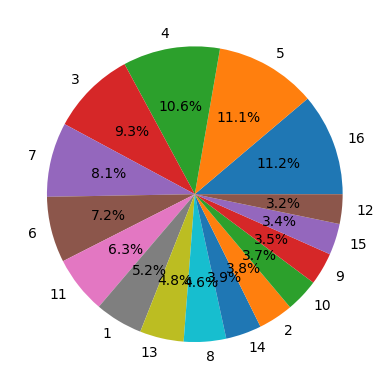

In [26]:

#Contar y normalizar
dfsizes = y_train.value_counts()/y_train.shape[0]
#Crear figura
fig, ax = plt.subplots()
#Pintar
ax.pie(list(dfsizes),labels=list(dfsizes.index) ,autopct='%1.1f%%')
plt.show()

In [8]:
def preprocess_text(text):
    # Tokenización
    tokens = word_tokenize(text.lower())
    # Eliminar stopwords y lematizar
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('spanish'))
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words])

In [ ]:
scorer = make_scorer(f1_score, average='weighted')

### RandomForestClassifier

#### Default Parameters

In [25]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

In [88]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000,
                                 preprocessor=<function preprocess_text at 0x31abed310>)),
                ('svd', TruncatedSVD(n_components=100)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [24]:
y_pred = pipeline.predict(X_test)

NameError: name 'pipeline' is not defined

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.75      0.78       101
           2       0.72      0.80      0.76        74
           3       0.86      0.90      0.88       179
           4       0.93      0.91      0.92       205
           5       0.92      0.94      0.93       214
           6       0.90      0.88      0.89       139
           7       0.92      0.85      0.88       158
           8       0.54      0.56      0.55        89
           9       0.62      0.70      0.65        69
          10       0.71      0.70      0.71        70
          11       0.78      0.72      0.75       122
          12       0.73      0.79      0.76        62
          13       0.70      0.82      0.75        93
          14       0.85      0.80      0.82        75
          15       0.91      0.79      0.85        66
          16       0.96      0.94      0.95       216

    accuracy                           0.84      1932
   macro avg       0.80   

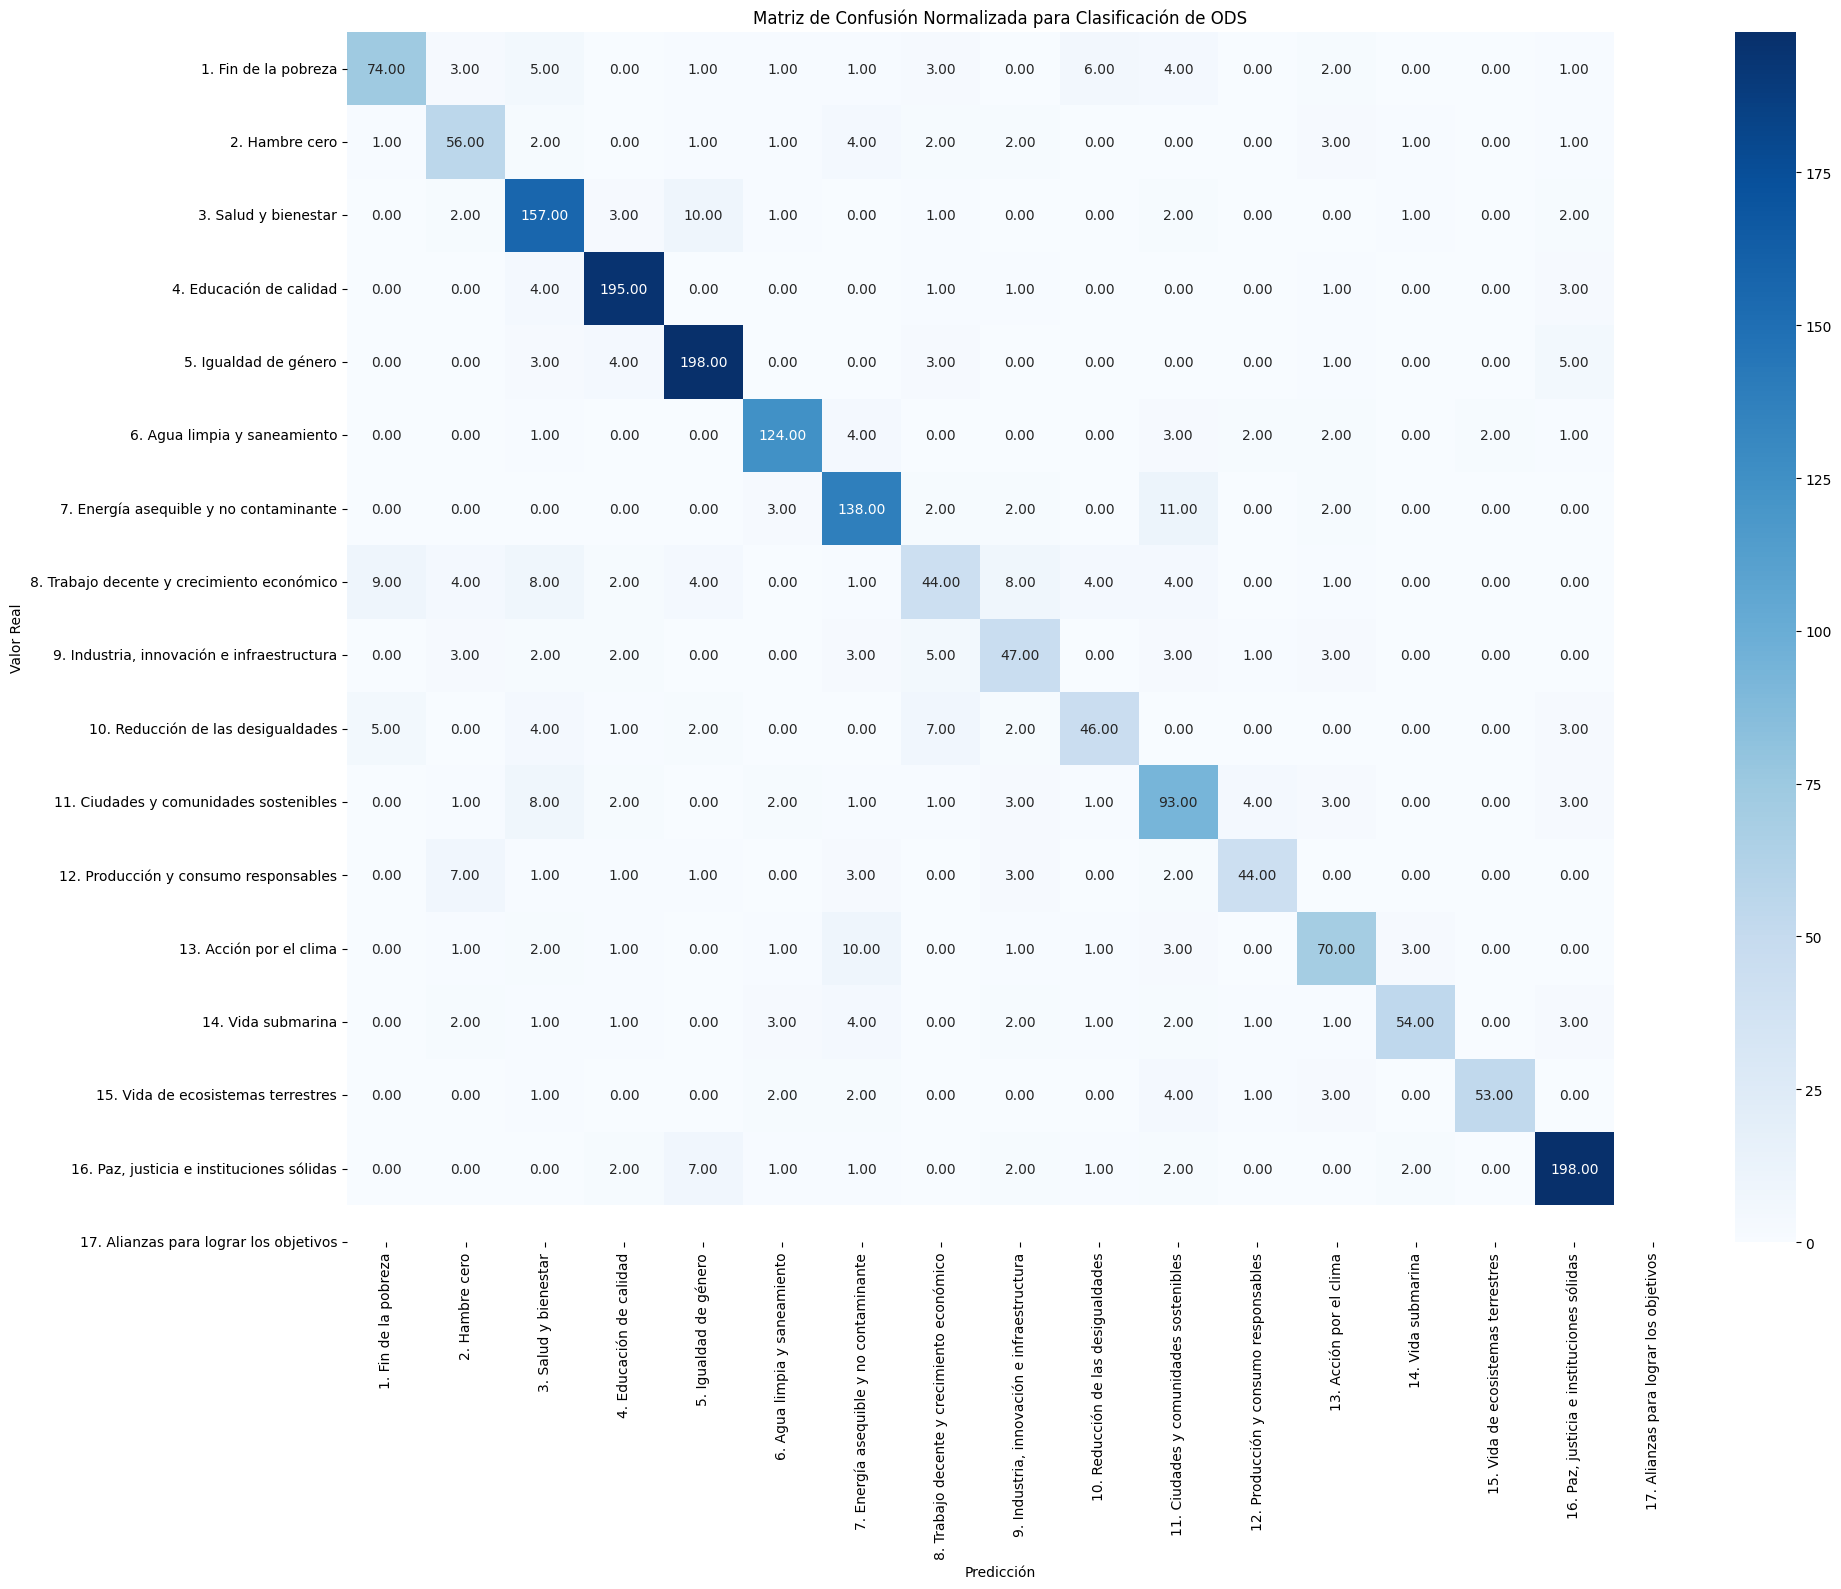

In [93]:
plot_confusion_matrix(y_test, y_pred)

#### Hyper Parameters

In [96]:
param_grid_rf = {
    'tfidf__max_features': [1000, 5000, 10000, None], # Número máximo de características (términos) a considerar
    'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],# Elimina términos que aparecen en más de x% de los documentos
    'tfidf__min_df': [1, 2, 5, 10], #  Elimina términos que aparecen en menos de x documentos
    'tfidf__norm': ['l1', 'l2', None], # Tipo de normalización aplicada después de la ponderación TF-IDF

    'svd__n_iter': [5, 10, 20], # Número de iteraciones para el algoritmo
    'svd__n_components': [50, 100, 200, 300], # Número de componentes (dimensiones reducidas) en los que deseas proyectar los datos

    'clf__n_estimators': [100, 200, 500, 1000], # Número de árboles en el bosque
    'clf__max_depth': [None, 10, 20, 30], # Profundidad máxima de los árboles
    'clf__max_features': ['auto', 'sqrt', 'log2', None], # Número máximo de características a considerar en cada división
    'clf__criterion': ['gini', 'entropy', 'log_loss'], # Función para medir la calidad de una división
    }

In [105]:
search = GridSearchCV(pipeline, param_grid_rf, scoring=scorer, refit='f1', n_jobs=-1, cv=5)

In [106]:

search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess_text at 0x31abed310>)),
                                       ('svd', TruncatedSVD()),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'clf__n_estimators': [50, 100, 200],
                         'svd__n_components': [50, 100, 200],
                         'tfidf__max_features': [1000, 5000, 10000]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [107]:
y_pred = search.best_estimator_.predict(X_test)

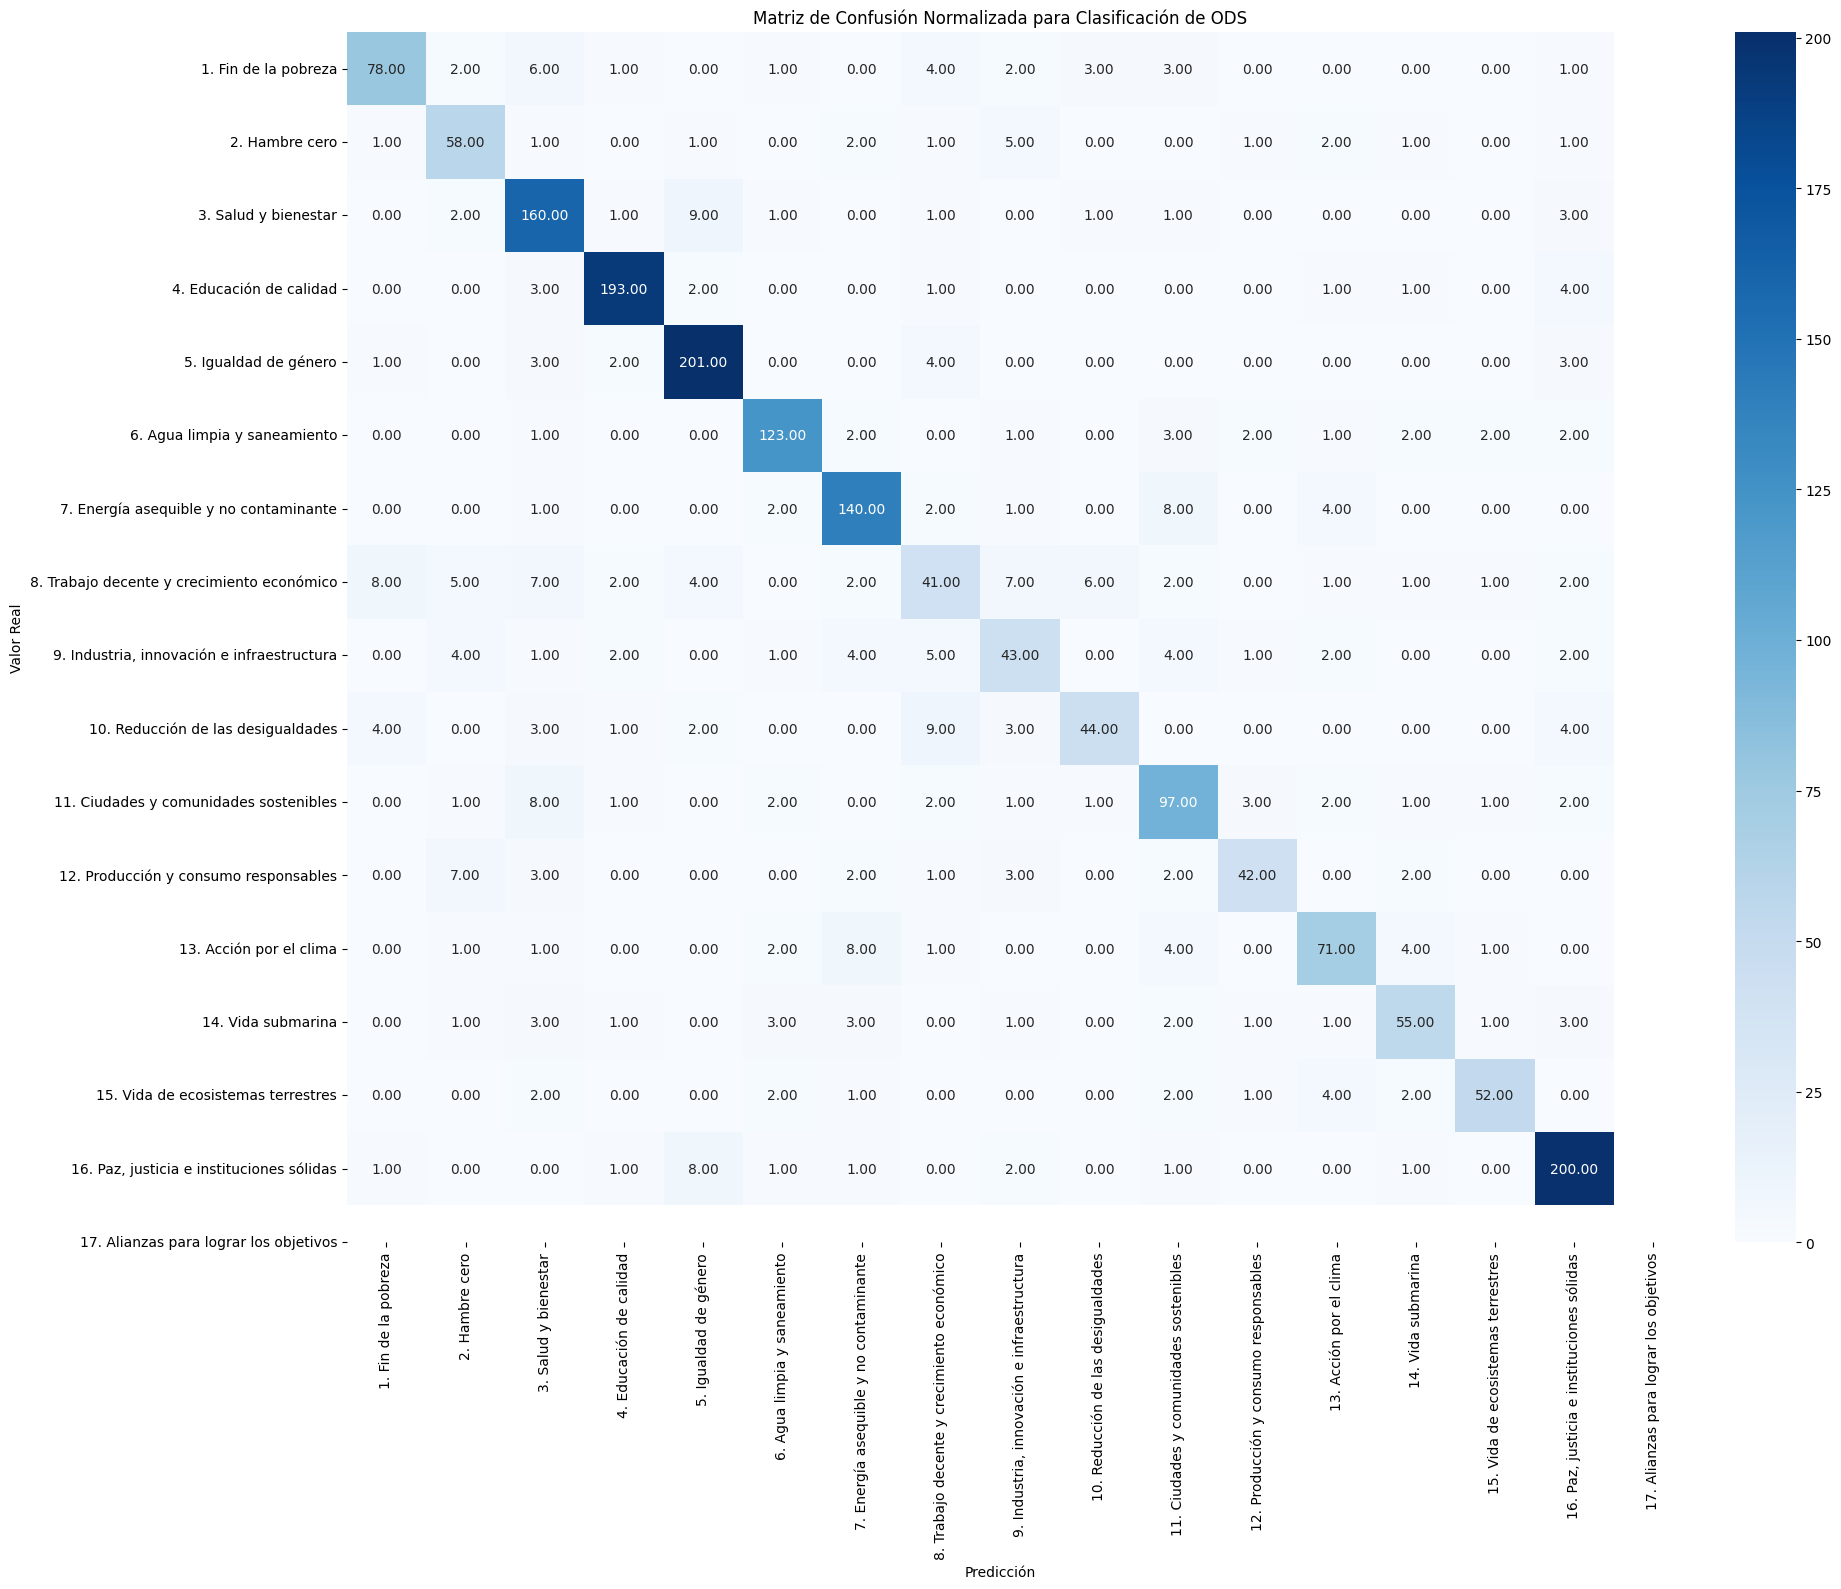

In [108]:

plot_confusion_matrix(y_test, y_pred)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.77      0.80       101
           2       0.72      0.78      0.75        74
           3       0.79      0.89      0.84       179
           4       0.94      0.94      0.94       205
           5       0.89      0.94      0.91       214
           6       0.89      0.88      0.89       139
           7       0.85      0.89      0.87       158
           8       0.57      0.46      0.51        89
           9       0.62      0.62      0.62        69
          10       0.80      0.63      0.70        70
          11       0.75      0.80      0.77       122
          12       0.82      0.68      0.74        62
          13       0.80      0.76      0.78        93
          14       0.79      0.73      0.76        75
          15       0.90      0.79      0.84        66
          16       0.88      0.93      0.90       216

    accuracy                           0.83      1932
   macro avg       0.80   

### CatBoost

#### Default Parameters

In [ ]:

pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced'))
])

In [ ]:
pipeline_2.fit(X_train, y_train)

In [ ]:
y_pred = pipeline_2.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(y_test, y_pred)

#### Hyper Parameters

In [12]:
param_grid_cat = {
    'tfidf__max_features': [1000, 5000, 10000, None], # Número máximo de características (términos) a considerar
    'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],# Elimina términos que aparecen en más de x% de los documentos
    'tfidf__min_df': [1, 2, 5, 10], #  Elimina términos que aparecen en menos de x documentos
    'tfidf__norm': ['l1', 'l2', None], # Tipo de normalización aplicada después de la ponderación TF-IDF

    'svd__n_iter': [5, 10, 20], # Número de iteraciones para el algoritmo
    'svd__n_components': [50, 100, 200, 300], # Número de componentes (dimensiones reducidas) en los que deseas proyectar los datos

    'clf__iterations': [100, 500, 1000], # Número de iteraciones o árboles a construir
    'clf__learning_rate': [0.01, 0.1, 0.3], # Tasa de aprendizaje para ajustar el modelo
    'clf__depth': [4, 6, 8, 10], # Profundidad máxima de los árboles
    'clf__l2_leaf_reg': [1, 3, 5, 10], # Regularización L2 para evitar el sobreajuste
    }

In [15]:
search_cat = GridSearchCV(pipeline_2, param_grid_cat, scoring=scorer, refit='f1', n_jobs=1, cv=5)

In [16]:
search_cat.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 1.9724165	total: 83.4ms	remaining: 4.09s
1:	learn: 1.6763799	total: 104ms	remaining: 2.5s
2:	learn: 1.4991291	total: 123ms	remaining: 1.92s
3:	learn: 1.3888253	total: 141ms	remaining: 1.62s
4:	learn: 1.2869179	total: 161ms	remaining: 1.45s
5:	learn: 1.1908476	total: 179ms	remaining: 1.31s
6:	learn: 1.1281227	total: 199ms	remaining: 1.23s
7:	learn: 1.0685598	total: 220ms	remaining: 1.15s
8:	learn: 1.0143934	total: 244ms	remaining: 1.11s
9:	learn: 0.9728135	total: 267ms	remaining: 1.07s
10:	learn: 0.9272741	total: 287ms	remaining: 1.02s
11:	learn: 0.8869451	total: 312ms	remaining: 989ms
12:	learn: 0.8590988	total: 336ms	remaining: 956ms
13:	learn: 0.8233261	total: 354ms	remaining: 911ms
14:	learn: 0.7982789	total: 375ms	remaining: 875ms
15:	learn: 0.7764263	total: 396ms	remaining: 840ms
16:	learn: 0.7451932	total: 415ms	remaining: 806ms
17:	learn: 0.7233531	total: 442ms	remaining: 785ms
18:	learn: 0.7056763	total: 463ms	remaining: 756ms
19:	learn: 0.690

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess_text at 0x3169950d0>)),
                                       ('svd', TruncatedSVD()),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x316c6dc10>)]),
             n_jobs=1,
             param_grid={'clf__n_estimators': [50, 100, 200],
                         'svd__n_components': [50, 100, 200],
                         'tfidf__max_features': [1000, 5000, 10000]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [18]:
y_pred = search_cat.best_estimator_.predict(X_test)

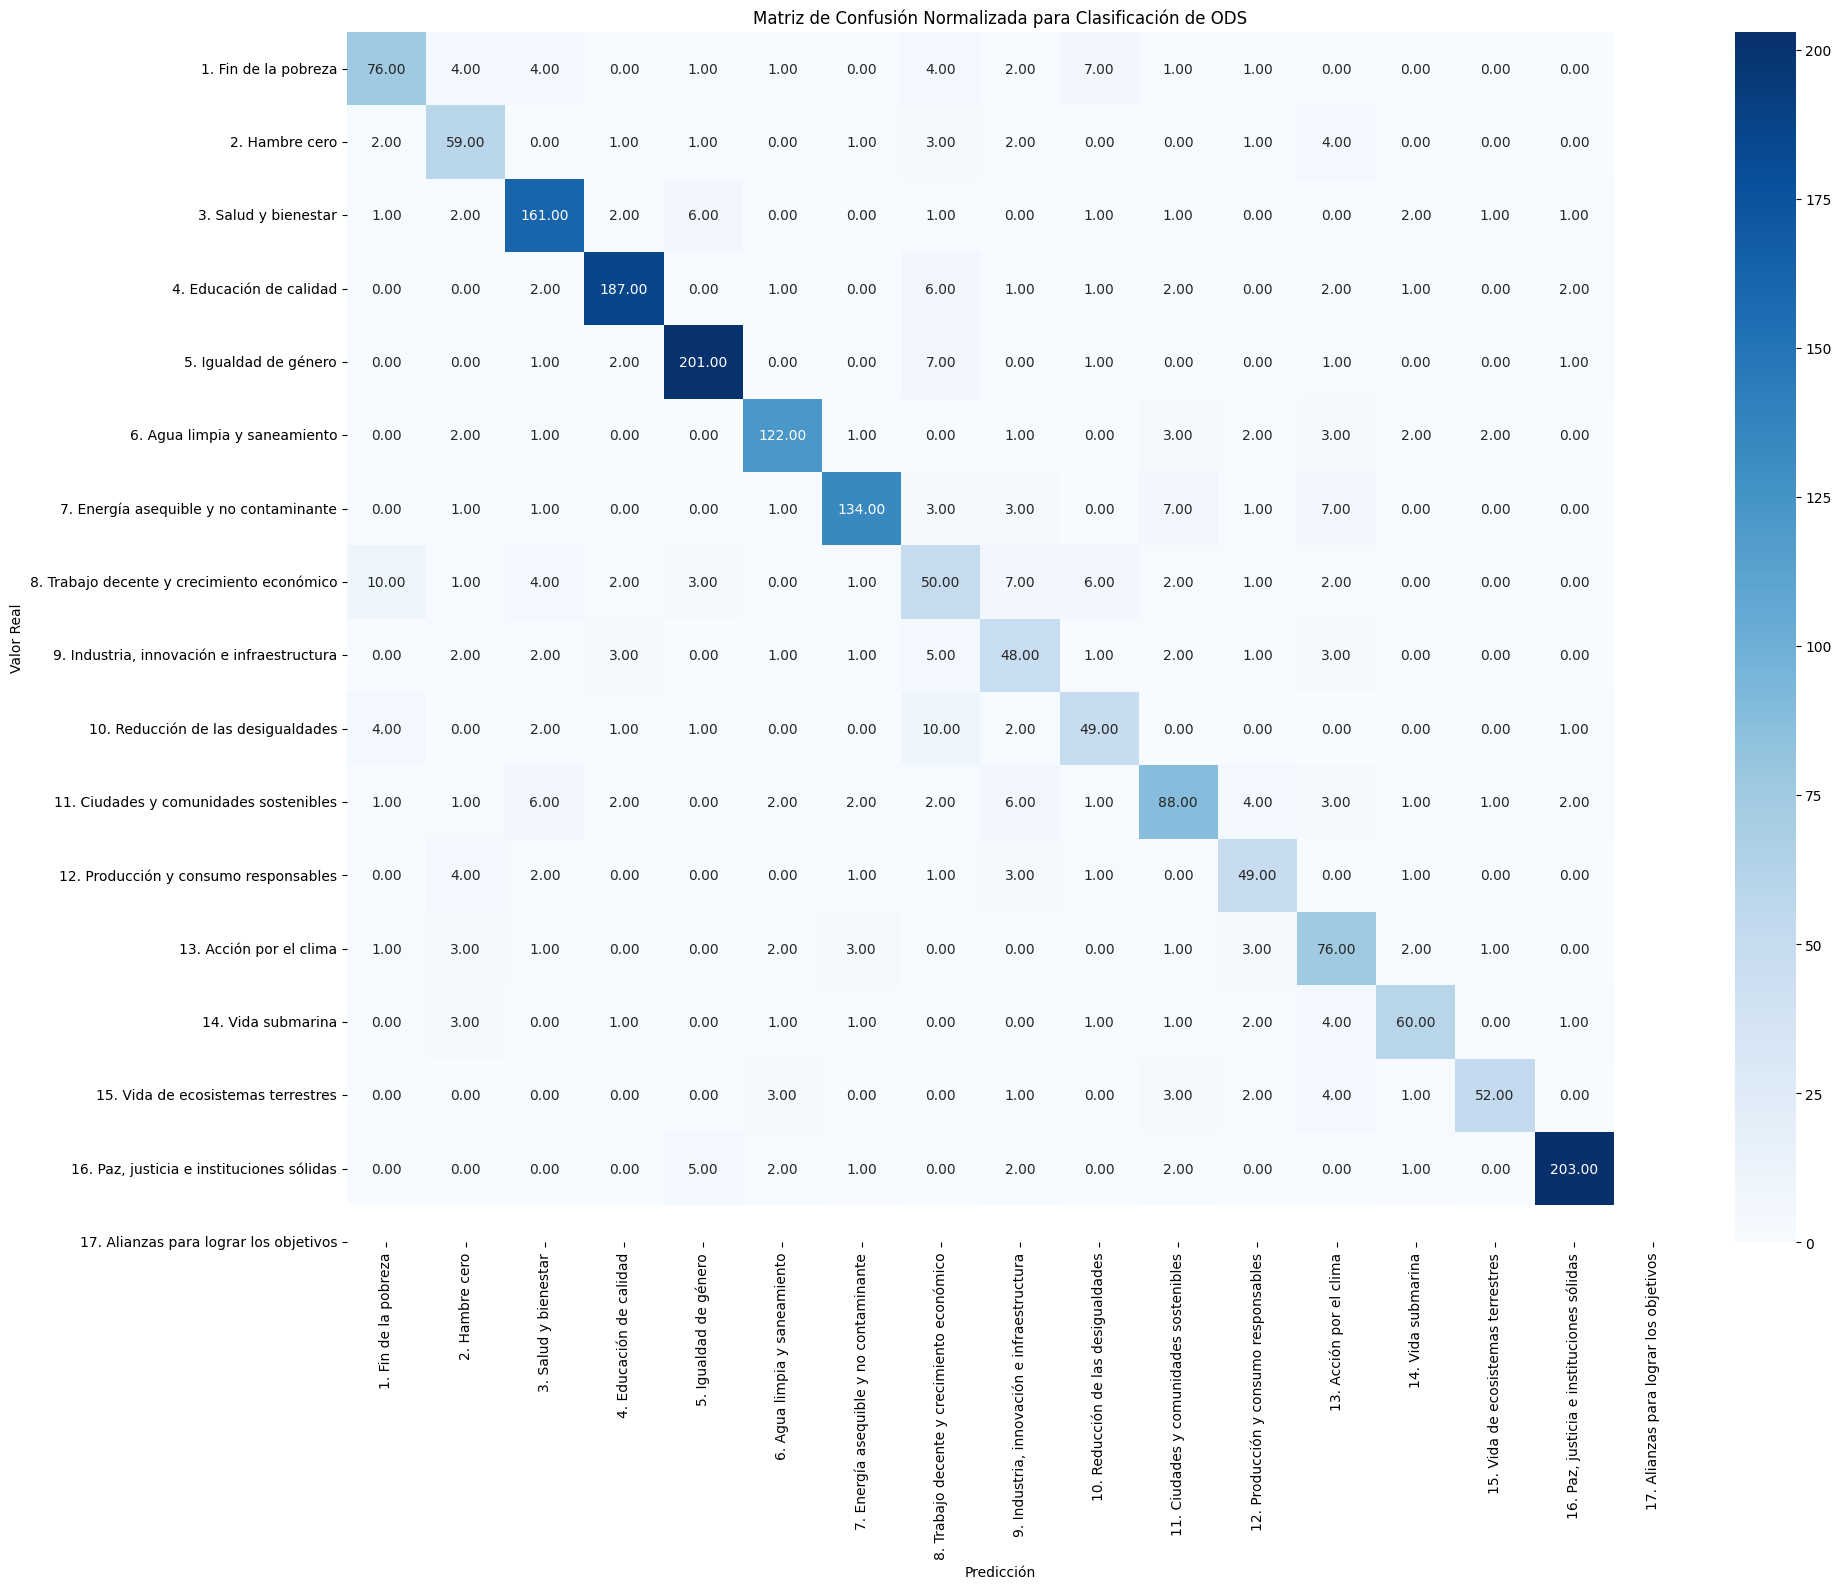

In [19]:
plot_confusion_matrix(y_test, y_pred)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.75      0.78       101
           2       0.72      0.80      0.76        74
           3       0.86      0.90      0.88       179
           4       0.93      0.91      0.92       205
           5       0.92      0.94      0.93       214
           6       0.90      0.88      0.89       139
           7       0.92      0.85      0.88       158
           8       0.54      0.56      0.55        89
           9       0.62      0.70      0.65        69
          10       0.71      0.70      0.71        70
          11       0.78      0.72      0.75       122
          12       0.73      0.79      0.76        62
          13       0.70      0.82      0.75        93
          14       0.85      0.80      0.82        75
          15       0.91      0.79      0.85        66
          16       0.96      0.94      0.95       216

    accuracy                           0.84      1932
   macro avg       0.80   

### SupportVectorClassifier

#### Default Parameters

In [ ]:
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', SVC(class_weight='balanced'))
])

In [ ]:
pipeline_3.fit(X_train, y_train)

In [ ]:
y_pred = pipeline_3.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(y_test, y_pred)

#### Hyper Parameters

In [21]:
param_grid_svc = {'tfidf__max_features': [1000, 5000, 10000, None], # Número máximo de características (términos) a considerar
                  'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],# Elimina términos que aparecen en más de x% de los documentos
                  'tfidf__min_df': [1, 2, 5, 10], #  Elimina términos que aparecen en menos de x documentos
                  'tfidf__norm': ['l1', 'l2', None], # Tipo de normalización aplicada después de la ponderación TF-IDF

                  'svd__n_iter': [5, 10, 20], # Número de iteraciones para el algoritmo
                  'svd__n_components': [50, 100, 200, 300], # Número de componentes (dimensiones reducidas) en los que deseas proyectar los dato

                  'clf__C': [0.1, 1, 10, 100], # Parámetro de regularización
                  'clf__kernel': ['linear', 'rbf', 'poly']} # Tipo de kernel a utilizar

In [ ]:
search_cat = GridSearchCV(pipeline_3, param_grid_svc, scoring=scorer, refit='f1', n_jobs=1, cv=5)

In [ ]:
y_pred = search_cat.best_estimator_.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))